## **ICR - Identifying Age-Related Conditions Dataset** 

Baseline model: The person has none of the three conditions

**Questions I have for the group:**
1. OK What should we do with the features that have lots of nulls? ('BQ' and 'EL'): mean imputing
2. OK How do we choose how many folds? Akabane et al.  mentions 5, Mythili et al. mentions 10, Kaggle notebook mentions 5: "golden standard is 10" (async)
3. Encode non-numeric data (EJ, Beta, Gamma, Epsilon)
4. Epsilon is a date: 
    - Do we want to leave only the year?
5. Should I run random trees with random data or standardize it so that it is comparable to other models that we run? (*standardized with PCA*)
6. Any idea why fold 6 isn't plotting? 


**Ask Cornelia:**
- Does it make sense to do class weighting and k-fold cross-validation? (ChatGPT says yes)
- Does imputing NaN in a year to -1 make sense?
- Is there any advantage to standardizing data for random trees?
- If I do EDA for missing values post_split, I have to re-run X_train because EDA must be done post split. 
- Does it matter if day, month year are floats instead of int?
- Can you explain the difference between the outputs of tSNE and PCA? 
- If we weight the classes AND do k-folds cross validation to address class imbalance, is accuracy still a poor evaluation metric? 


**To-dos:**
- Turn the "dummies" into a function 
- Check whether the random trees model includes bagging (read documentation)
- Imputing: when to use mean imputation vs. regression imputation
- Set seed so that split is always the same
- Get aucrc to work. Maybe try this:  https://towardsdatascience.com/tensorflow-decision-forests-a-comprehensive-introduction-3b6056a6d6b0


In [ ]:
# Akabane et al. test/train split
akabane_train = (6564/8792)*100
akabane_test = (2228/8792)*100

print(f"Akabane et al train: {akabane_train:.0f}%, test: {akabane_test:.0f}%")
print("Alageel et al train: 80%, test: 20%")

#### ``Objectives``

#### ``Motivation``

#### ``Data``

### Step 1: Import libraries

---

In [ ]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sklearn.metrics as metrics


from sklearn.model_selection import KFold
from mlxtend.plotting import heatmap
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE



#improve figure resolution
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'


pd.set_option('display.max_columns', None) #show all columns
pd.set_option('display.max_rows', None) #show all columns



### Step 2: Define functions

---

In [ ]:
#auprc for metrics
def auprc(y_true, y_pred):
    precision, recall, _ = metrics.precision_recall_curve(y_true, y_pred)
    return metrics.auc(recall, precision)

### Step 3: Read data

---

In [ ]:
#set working directory
os.chdir('/Users/ecompu/Library/CloudStorage/OneDrive-Personal/Berkeley/W207_Machine_Learning/mids-207-final-project-summer23-Burzon-Brown-Caldera-Gomez/icr-identify-age-related-conditions/')

dataset_df = pd.read_csv('train.csv')
print("Full dataset shape is {}".format(dataset_df.shape)) 

In [ ]:
# data
dataset_df.head()

In [ ]:
# metadata
greeks_df = pd.read_csv('greeks.csv')
greeks_df.head()


### Step 4: Preprocess data

---

In [ ]:
# merge greeks and dataset
all_vars = dataset_df.merge(greeks_df, left_on='Id', right_on='Id')
all_vars.head()

In [ ]:
# check column names. Drop Alpha and Id because its also the class , and Id irrelevant 
all_vars = all_vars.drop(['Alpha','Id'], axis=1)
all_vars.columns

In [ ]:
# Check datatypes for each column
all_vars.dtypes

In [ ]:
#Change Unknown to Nan in order to format dates
all_vars['Epsilon'] = all_vars['Epsilon'].replace('Unknown', np.nan)  # Replace 'Unknown' with NaN

#split the date into DD/MM/YYYY
all_vars['Epsilon'] = pd.to_datetime(all_vars['Epsilon'])  # Convert the column to datetime format
all_vars['Day'] = all_vars['Epsilon'].dt.day.fillna(-1).astype(int)
all_vars['Month'] = all_vars['Epsilon'].dt.month.fillna(-1).astype(int)
all_vars['Year'] = all_vars['Epsilon'].dt.year.fillna(-1).astype(int)


all_vars['Day']
all_vars['Month']
all_vars['Year']

In [ ]:
all_vars.dtypes

In [ ]:
# dummies for categorical variables alpha, beta, gamma, ej
columns_to_dummy = ['Beta', 'Gamma', 'Delta','EJ']


# beta
beta_dummy = pd.get_dummies(
    all_vars['Beta'], prefix='Beta', dtype=int
)

# gamma
gamma_dummy = pd.get_dummies(
    all_vars['Gamma'], prefix='Gamma', dtype=int
)


# delta
delta_dummy = pd.get_dummies(
    all_vars['Delta'],prefix='Delta', dtype=int
)

# ej
ej_dummy = pd.get_dummies(
    all_vars['EJ'],prefix='EJ', dtype=int
)


# add to initial df
with_dummies_df = pd.concat(
    [all_vars,beta_dummy,gamma_dummy,ej_dummy],
    axis=1
)

with_dummies_df.dtypes

In [ ]:
#drop Beta, Gamma, Delta, Epsilon
all_vars = with_dummies_df.drop(['Beta','Gamma','Delta','Epsilon','EJ'], axis=1)
all_vars.columns


``split data into training and test``

In [ ]:
# define outcome #
##################
y = all_vars['Class'].values
y

# define features #
###################
columns = [i for i in all_vars.columns if i not in ['Class']] 
X = all_vars[columns].values


# split #
#########
split = (0.8,0.2) #80% training and 20% test
shuffle = np.random.permutation(np.arange(y.shape[0])) 
X, y = X[shuffle], y[shuffle]

splits = np.multiply(len(y), split).astype(int) 
X_train, X_test = np.split(X, [splits[0]])
y_train, y_test = np.split(y, [splits[0]])


# df for y_train and X_train #
##############################
# easier for EDA later on
df_train = pd.concat(
    [pd.DataFrame(y_train), pd.DataFrame(X_train)],
    axis=1
)

# # rename columns
df_train.columns=['Class', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP',
       'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB',
       'EE', 'EG', 'EH', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR',
       'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL',  'Day', 'Month',
       'Year', 'Beta_A', 'Beta_B', 'Beta_C', 'Gamma_A', 'Gamma_B', 'Gamma_E',
       'Gamma_F', 'Gamma_G', 'Gamma_H', 'Gamma_M', 'Gamma_N', 'EJ_A', 'EJ_B']

In [ ]:
print('Shape X_train: ', X_train.shape, '\nShape X_test: ', X_test.shape,
      '\nShape y_train: ', y_train.shape, '\nShape y_test:', y_test.shape)

### Step 5: EDA

---


1. Columns: 1 Class column (0/1) and 71 features (with one-hot encoding for categorical variables)
2. Check data types: Features are float64, one-hot encoding are int, Label 'Class' is int64
3. Count number of nulls per feature: imputed with mean value 

BQ    49
CB     1
CC     2
EL    51
FC     1
FS     2

4. Check for duplicates: none
5. Summary statistics: The distributions of the features vary, so we would probably benefit from standarization. 
6. Histogram of variables: The labels show class imbalance, so we'll do k-fold cross-validation 


In [ ]:
# Look at the dataset
df_train.dtypes
# df_train.head()
# df_train.shape[1]
# df_train.describe()

In [ ]:
# Find which columns have missing values 
sum_null = df_train.isnull().sum()
sum_null[sum_null!=0]

In [ ]:
# impute missing values with the mean 
mean_values = df_train.mean()
df_train.fillna(mean_values, inplace=True)

In [ ]:
# Check whether we have duplicated data: no 
df_train.duplicated().sum()

In [ ]:
# Calculate the number of negative and positive values in `Class` column
neg, pos = np.bincount(df_train['Class'])
# Calculate total samples
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

In [ ]:
#check distributions of features and labels
columns = df_train.columns.tolist()

fig, axes = plt.subplots(nrows=7, ncols=8, figsize=(20, 20))
fig.tight_layout(pad=2.0)

for idx, ax in enumerate(axes.flatten()):
    if idx < len(columns):
        ax.hist(df_train[columns[idx]])
        ax.set_xlabel(columns[idx])
    else:
        ax.axis('off')

# Show the plot
plt.show()

In [ ]:
# bivariate interactions
FEATURE_COLUMNS = [i for i in df_train.columns if i not in ["Class"]]
feature_train_df = df_train[FEATURE_COLUMNS]
corr = feature_train_df.corr()
fig = plt.figure( figsize=(20, 20))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(feature_train_df.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(feature_train_df.columns)
ax.set_yticklabels(feature_train_df.columns)
plt.show()

## Step 6: Feature Engineering

---

``PCA``

In [ ]:
#highly correlated variables

corr_matrix = feature_train_df.corr().abs()

# print(corr_matrix)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr = [column for column in upper.columns if any(upper[column] > 0.95)]
# high_corr
# df.drop(high_corr, axis=1, inplace=True)#if we want to drop the highly correlated vars (but I think running PCA makes more sense)



In [ ]:
# 1. Standardize features

X_train = df_train.drop(["Class"], axis=1)
sc = StandardScaler()
sc.fit(X_train)
print("Mean: ", sc.mean_, '\nVariance: ', sc.var_)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [ ]:
# 2. Construct the covariance matrix
cov_matrix = np.cov(X_train_std.T)
pd.DataFrame(cov_matrix)

In [ ]:
#3. Decompose into eigenvalues and eigenvectors
eigen_values, eigen_vectors = np.linalg.eigh(cov_matrix)

In [ ]:
#rank them in decreasing order 
# compute the explained variance ratio
sum_eigen_values = sum(eigen_values)
print('Sum eigenvalues: ', sum_eigen_values)

expl_var_ratio = [i/sum_eigen_values for i in sorted(eigen_values, reverse=True)]
print('\nExplained variance ratio:')
pd.DataFrame(expl_var_ratio)

In [ ]:
# visualize the explained variance ratio and the cumulative explained variance ratio
x_axis = range(1,len(eigen_values)+1)
y_axis = expl_var_ratio

# plot individual ratio
plt.rcParams["figure.figsize"] = (20, 10)
plt.bar(x_axis, y_axis, label='Individual explained variance')
# plot cumulative ratio
plt.step(x_axis, np.cumsum(y_axis), where='mid', label='Cumulative explained variance')

# legend, labels
plt.legend()
plt.xticks(x_axis)
plt.ylabel('Explained variance ratio');
plt.xlabel('Principal component index (based on sorted eigenvalue)');

In [ ]:
#select k=10  eigenvectors, based on the 6 largest eigenvalues, explaining around half the variability 
# create eigen pairs of vectors and values
eigen_pairs = [(eigen_values[i], eigen_vectors[:,i]) for i in range(len(eigen_vectors))]

# transform to df
eigen_pairs = pd.DataFrame(eigen_pairs)
eigen_pairs.rename(columns={0: 'eigen_value', 1: 'eigen_vector'}, inplace=True)
# eigen_pairs.head()

# select the top 10 eigenvectors based on the eigenvalue
top10_eigen_vectors = eigen_pairs.nlargest(10, 'eigen_value')['eigen_vector'].values.tolist()
top10_eigen_vectors

In [ ]:
# Construct the projection matrix, W, using the top 10 eigenvectors

w = np.hstack((top10_eigen_vectors[0][:, np.newaxis],
               top10_eigen_vectors[1][:, np.newaxis],
               top10_eigen_vectors[2][:, np.newaxis],
               top10_eigen_vectors[3][:, np.newaxis],
               top10_eigen_vectors[4][:, np.newaxis],
               top10_eigen_vectors[5][:, np.newaxis],
               top10_eigen_vectors[6][:, np.newaxis],
               top10_eigen_vectors[7][:, np.newaxis],
               top10_eigen_vectors[8][:, np.newaxis],
               top10_eigen_vectors[9][:, np.newaxis]
              ))
print('Matrix W:\n', w)
print('\nSize of Matrix W: ', w.shape)

In [131]:
# 7. Transform original X-Train with the projection matrix
# training data
X_train_pca = X_train_std.dot(w)
pd.DataFrame(X_train_pca).head()


AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [134]:
df_train_pca = pd.concat(
    [pd.DataFrame(y_train), pd.DataFrame(X_train_pca)],
    axis=1
)



df_train_pca.columns=['Class', 'PCA_1','PCA_2','PCA_3','PCA_4','PCA_5','PCA_6','PCA_7','PCA_8','PCA_9','PCA_10']
df_train_pca.head()


,Class,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10
0,1,-0.052941,1.799030,1.485245,-1.109579,0.618847,0.913905,0.293644,-1.417548,-0.040397,-0.981979
1,0,1.995241,-1.583674,-1.987573,0.898169,0.419377,-1.608255,-0.034199,-1.320400,-0.172087,-0.175782
2,1,-2.542004,3.578700,0.972693,-2.574013,0.682544,1.147635,1.911247,-1.382705,-1.246660,-1.809121
3,1,-1.673478,1.049832,-2.067781,-2.434092,2.288461,1.402751,-0.238703,2.235162,-1.831284,1.881381
4,1,0.501074,2.165121,2.164111,1.075703,1.069367,0.836276,-0.302621,-0.923222,0.173729,0.252797


In [ ]:
# test data
X_test_pca = X_test_std.dot(w)
pd.DataFrame(X_test_pca).head()

In [ ]:
#visualize first 2 PCA 
colors = ['grey', 'orange', 'blue']
markers = ['s', 'x', 'o']

# plot
for class_value, color, marker in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==class_value, 0],
                X_train_pca[y_train==class_value, 1],
                color = color, label = class_value, marker=marker)
    
# legend, axes
plt.legend(loc='best')
plt.xlabel('PCA1')
plt.ylabel('PCA2');

``tSNE``

In [ ]:
#create an instance of the tsne class
tsne = TSNE(n_components=2, random_state=42)

#fit the model to xTrain
tsne_X_train = tsne.fit_transform(X_train)

# Visualize the embedded data
plt.scatter(tsne_X_train[:, 0], tsne_X_train[:, 1])
plt.title("t-SNE Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


### Step 7: Learning Model

---

1. Class weighting
2. K-fold cross-validation
3. Hyperparameter tuning: Number of trees, depth of trees

``random forest with bagging``

In [135]:
#class weighting

# Calculate the number of samples for each label.
neg, pos = np.bincount(df_train_pca['Class'])

# Calculate total samples.
total = neg + pos

# Calculate the weight for each label.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.62
Weight for class 1: 2.54


``k-fold cross validation``

In [136]:
# len(df_train) #with raw data
len(df_train_pca) #with pca same length....

493

In [137]:
#estimate performance with OOF 
# Create list of ids for the creation of oof dataframe.
ID_LIST = df_train_pca.index


# # Create a dataframe of required size with zero values (493)
oof = pd.DataFrame(data=np.zeros((len(ID_LIST),1)), index=ID_LIST)

# Create an empty dictionary to store the models trained for each fold.
models = {}

# Create empty dict to save metrics for the models trained for each fold.
accuracy = {}
cross_entropy = {}
# auprc = {} can't get it to work, will try later


# Save the name of the label column to a variable.
label = "Class"

In [138]:
kf = KFold(n_splits=10)
ft_cols = df_train_pca.columns
ft_cols

Index(['Class', 'PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5', 'PCA_6', 'PCA_7',
       'PCA_8', 'PCA_9', 'PCA_10'],
      dtype='object')

`Build the model` 



In [139]:
for i, (train_index, valid_index) in enumerate(kf.split(X=df_train_pca)):
        print('##### Fold',i+1)

        # Fetch values corresponding to the index 
        train_df = df_train_pca.iloc[train_index]
        valid_df = df_train_pca.iloc[valid_index]
        valid_ids = valid_df.index.values
        
        # Select only feature columns for training.
        train_df = train_df[ft_cols]
        valid_df = valid_df[ft_cols]
        

        train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label)
        valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=label)

        # Define the model and metrics
        rf = tfdf.keras.RandomForestModel()

##### Fold 1
Use /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmp56a1ertl as temporary training directory
##### Fold 2
Use /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmp0z34up0a as temporary training directory
##### Fold 3
Use /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmpu0msmnq3 as temporary training directory
##### Fold 4
Use /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmpoi4bqcb8 as temporary training directory
##### Fold 5
Use /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmpff1v026x as temporary training directory
##### Fold 6
Use /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmpeyjw5aoe as temporary training directory
##### Fold 7
Use /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmp39w5tteu as temporary training directory
##### Fold 8
Use /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmp4yhvkja2 as temporary training directory
##### Fold 9
Use /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmpdo2gmzsr as temporary training directory
##### Fold

`Compile the model `

In [140]:
for i, (train_index, valid_index) in enumerate(kf.split(X=df_train_pca)):
    rf.compile(metrics=["accuracy", "binary_crossentropy"]) #change from accuracy to AUPRC

`Fit the model `

In [141]:
for i, (train_index, valid_index) in enumerate(kf.split(X=df_train_pca)):

    rf.fit(x=train_ds, class_weight=class_weight)
            
    # Store the model
    models[f"fold_{i+1}"] = rf
            
    # Predict OOF value for validation data
    predict = rf.predict(x=valid_ds)
            
    # Store the predictions in oof dataframe
    oof.loc[valid_ids, 0] = predict.flatten() 
            
    # Evaluate and store the metrics in respective dicts
    evaluation = rf.evaluate(x=valid_ds,return_dict=True)
    accuracy[f"fold_{i+1}"] = evaluation["accuracy"]
    cross_entropy[f"fold_{i+1}"]= evaluation["binary_crossentropy"]

Reading training dataset...


2023-07-16 14:25:56.321143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [444]
	 [[{{node Placeholder/_1}}]]


Training dataset read in 0:00:09.810752. Found 444 examples.
Training model...
Model trained in 0:00:00.151466
Compiling model...


[INFO 23-07-16 14:26:06.0637 -05 kernel.cc:1242] Loading model from path /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmpcr2hswlj/model/ with prefix 9fe20fe0c7de4899
[INFO 23-07-16 14:26:06.1036 -05 decision_forest.cc:660] Model loaded with 300 root(s), 9872 node(s), and 10 input feature(s).
[INFO 23-07-16 14:26:06.1039 -05 abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-07-16 14:26:06.1042 -05 kernel.cc:1074] Use fast generic engine
2023-07-16 14:26:06.124837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype double and shape [444]
	 [[{{node Placeholder/_7}}]]


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.
1/1 [==============================] - 0s 52ms/step


2023-07-16 14:26:09.408424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype double and shape [49]
	 [[{{node Placeholder/_3}}]]


1/1 [==============================] - 1s 840ms/step - loss: 0.0000e+00 - accuracy: 0.9184 - binary_crossentropy: 0.1584
Reading training dataset...
Training dataset read in 0:00:00.118305. Found 444 examples.
Training model...
Model trained in 0:00:00.085163
Compiling model...


2023-07-16 14:26:10.388283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype int64 and shape [444]
	 [[{{node Placeholder/_10}}]]
[INFO 23-07-16 14:26:10.4827 -05 kernel.cc:1242] Loading model from path /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmpcr2hswlj/model/ with prefix 9fe20fe0c7de4899
[INFO 23-07-16 14:26:10.5113 -05 decision_forest.cc:660] Model loaded with 300 root(s), 9872 node(s), and 10 input feature(s).
[INFO 23-07-16 14:26:10.5113 -05 kernel.cc:1074] Use fast generic engine
2023-07-16 14:26:10.523464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dt

Model compiled.
1/1 [==============================] - 0s 173ms/step - loss: 0.0000e+00 - accuracy: 0.9184 - binary_crossentropy: 0.1584
Reading training dataset...
Training dataset read in 0:00:00.064071. Found 444 examples.
Training model...
Model trained in 0:00:00.081970
Compiling model...


2023-07-16 14:26:10.953760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype double and shape [444]
	 [[{{node Placeholder/_7}}]]
[INFO 23-07-16 14:26:11.0273 -05 kernel.cc:1242] Loading model from path /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmpcr2hswlj/model/ with prefix 9fe20fe0c7de4899
[INFO 23-07-16 14:26:11.0544 -05 decision_forest.cc:660] Model loaded with 300 root(s), 9872 node(s), and 10 input feature(s).
[INFO 23-07-16 14:26:11.0546 -05 kernel.cc:1074] Use fast generic engine
2023-07-16 14:26:11.066844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dty

Model compiled.


1/1 [==============================] - 0s 183ms/step - loss: 0.0000e+00 - accuracy: 0.9184 - binary_crossentropy: 0.1584
Reading training dataset...
Training dataset read in 0:00:00.064652. Found 444 examples.
Training model...
Model trained in 0:00:00.087261
Compiling model...


2023-07-16 14:26:11.507647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [444]
	 [[{{node Placeholder/_2}}]]
[INFO 23-07-16 14:26:11.5906 -05 kernel.cc:1242] Loading model from path /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmpcr2hswlj/model/ with prefix 9fe20fe0c7de4899
[INFO 23-07-16 14:26:11.6160 -05 decision_forest.cc:660] Model loaded with 300 root(s), 9872 node(s), and 10 input feature(s).
[INFO 23-07-16 14:26:11.6160 -05 kernel.cc:1074] Use fast generic engine
2023-07-16 14:26:11.628262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dty

Model compiled.
1/1 [==============================] - 0s 168ms/step - loss: 0.0000e+00 - accuracy: 0.9184 - binary_crossentropy: 0.1584
Reading training dataset...
Training dataset read in 0:00:00.062589. Found 444 examples.
Training model...
Model trained in 0:00:00.102216
Compiling model...


2023-07-16 14:26:12.032565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [444]
	 [[{{node Placeholder/_1}}]]
[INFO 23-07-16 14:26:12.1265 -05 kernel.cc:1242] Loading model from path /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmpcr2hswlj/model/ with prefix 9fe20fe0c7de4899
[INFO 23-07-16 14:26:12.1537 -05 decision_forest.cc:660] Model loaded with 300 root(s), 9872 node(s), and 10 input feature(s).
[INFO 23-07-16 14:26:12.1537 -05 kernel.cc:1074] Use fast generic engine
2023-07-16 14:26:12.166582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dty

Model compiled.
1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 165ms/step - loss: 0.0000e+00 - accuracy: 0.9184 - binary_crossentropy: 0.1584
Reading training dataset...
Training dataset read in 0:00:00.062839. Found 444 examples.
Training model...
Model trained in 0:00:00.082651
Compiling model...


2023-07-16 14:26:12.623180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype double and shape [444]
	 [[{{node Placeholder/_8}}]]
[INFO 23-07-16 14:26:12.7014 -05 kernel.cc:1242] Loading model from path /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmpcr2hswlj/model/ with prefix 9fe20fe0c7de4899
[INFO 23-07-16 14:26:12.7281 -05 decision_forest.cc:660] Model loaded with 300 root(s), 9872 node(s), and 10 input feature(s).
[INFO 23-07-16 14:26:12.7282 -05 kernel.cc:1074] Use fast generic engine
2023-07-16 14:26:12.740064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dty

Model compiled.
1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 214ms/step - loss: 0.0000e+00 - accuracy: 0.9184 - binary_crossentropy: 0.1584
Reading training dataset...
Training dataset read in 0:00:00.160949. Found 444 examples.
Training model...


2023-07-16 14:26:13.281226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [444]
	 [[{{node Placeholder/_2}}]]


Model trained in 0:00:00.090053
Compiling model...


[INFO 23-07-16 14:26:13.3831 -05 kernel.cc:1242] Loading model from path /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmpcr2hswlj/model/ with prefix 9fe20fe0c7de4899
[INFO 23-07-16 14:26:13.4122 -05 decision_forest.cc:660] Model loaded with 300 root(s), 9872 node(s), and 10 input feature(s).
[INFO 23-07-16 14:26:13.4123 -05 kernel.cc:1074] Use fast generic engine
2023-07-16 14:26:13.426957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype double and shape [444]
	 [[{{node Placeholder/_9}}]]


Model compiled.
1/1 [==============================] - 0s 163ms/step - loss: 0.0000e+00 - accuracy: 0.9184 - binary_crossentropy: 0.1584
Reading training dataset...
Training dataset read in 0:00:00.060222. Found 444 examples.
Training model...
Model trained in 0:00:00.080133
Compiling model...


2023-07-16 14:26:13.851911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype double and shape [444]
	 [[{{node Placeholder/_7}}]]
[INFO 23-07-16 14:26:13.9263 -05 kernel.cc:1242] Loading model from path /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmpcr2hswlj/model/ with prefix 9fe20fe0c7de4899
[INFO 23-07-16 14:26:13.9511 -05 decision_forest.cc:660] Model loaded with 300 root(s), 9872 node(s), and 10 input feature(s).
[INFO 23-07-16 14:26:13.9511 -05 kernel.cc:1074] Use fast generic engine
2023-07-16 14:26:13.963672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dty

Model compiled.
1/1 [==============================] - 0s 161ms/step - loss: 0.0000e+00 - accuracy: 0.9184 - binary_crossentropy: 0.1584
Reading training dataset...
Training dataset read in 0:00:00.062812. Found 444 examples.
Training model...
Model trained in 0:00:00.088441
Compiling model...


2023-07-16 14:26:14.356596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype double and shape [444]
	 [[{{node Placeholder/_6}}]]
[INFO 23-07-16 14:26:14.4391 -05 kernel.cc:1242] Loading model from path /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmpcr2hswlj/model/ with prefix 9fe20fe0c7de4899
[INFO 23-07-16 14:26:14.4637 -05 decision_forest.cc:660] Model loaded with 300 root(s), 9872 node(s), and 10 input feature(s).
[INFO 23-07-16 14:26:14.4637 -05 kernel.cc:1074] Use fast generic engine
2023-07-16 14:26:14.475815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dty

Model compiled.
1/1 [==============================] - 0s 158ms/step - loss: 0.0000e+00 - accuracy: 0.9184 - binary_crossentropy: 0.1584
Reading training dataset...
Training dataset read in 0:00:00.058116. Found 444 examples.
Training model...
Model trained in 0:00:00.085785
Compiling model...


2023-07-16 14:26:14.864671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [444]
	 [[{{node Placeholder/_0}}]]
[INFO 23-07-16 14:26:14.9443 -05 kernel.cc:1242] Loading model from path /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmpcr2hswlj/model/ with prefix 9fe20fe0c7de4899
[INFO 23-07-16 14:26:14.9688 -05 decision_forest.cc:660] Model loaded with 300 root(s), 9872 node(s), and 10 input feature(s).
[INFO 23-07-16 14:26:14.9688 -05 kernel.cc:1074] Use fast generic engine
2023-07-16 14:26:14.982057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dty

Model compiled.
1/1 [==============================] - 0s 173ms/step - loss: 0.0000e+00 - accuracy: 0.9184 - binary_crossentropy: 0.1584


`Visualize the model`

In [145]:
with open("fold_1.html", "w") as f: 
    f.write(tfdf.model_plotter.plot_model(models['fold_1'], tree_idx=0, max_depth=3))


with open("fold_2.html", "w") as f: 
    f.write(tfdf.model_plotter.plot_model(models['fold_2'], tree_idx=0, max_depth=3))


with open("fold_3.html", "w") as f: 
    f.write(tfdf.model_plotter.plot_model(models['fold_3'], tree_idx=0, max_depth=3))   



`Plot loss`

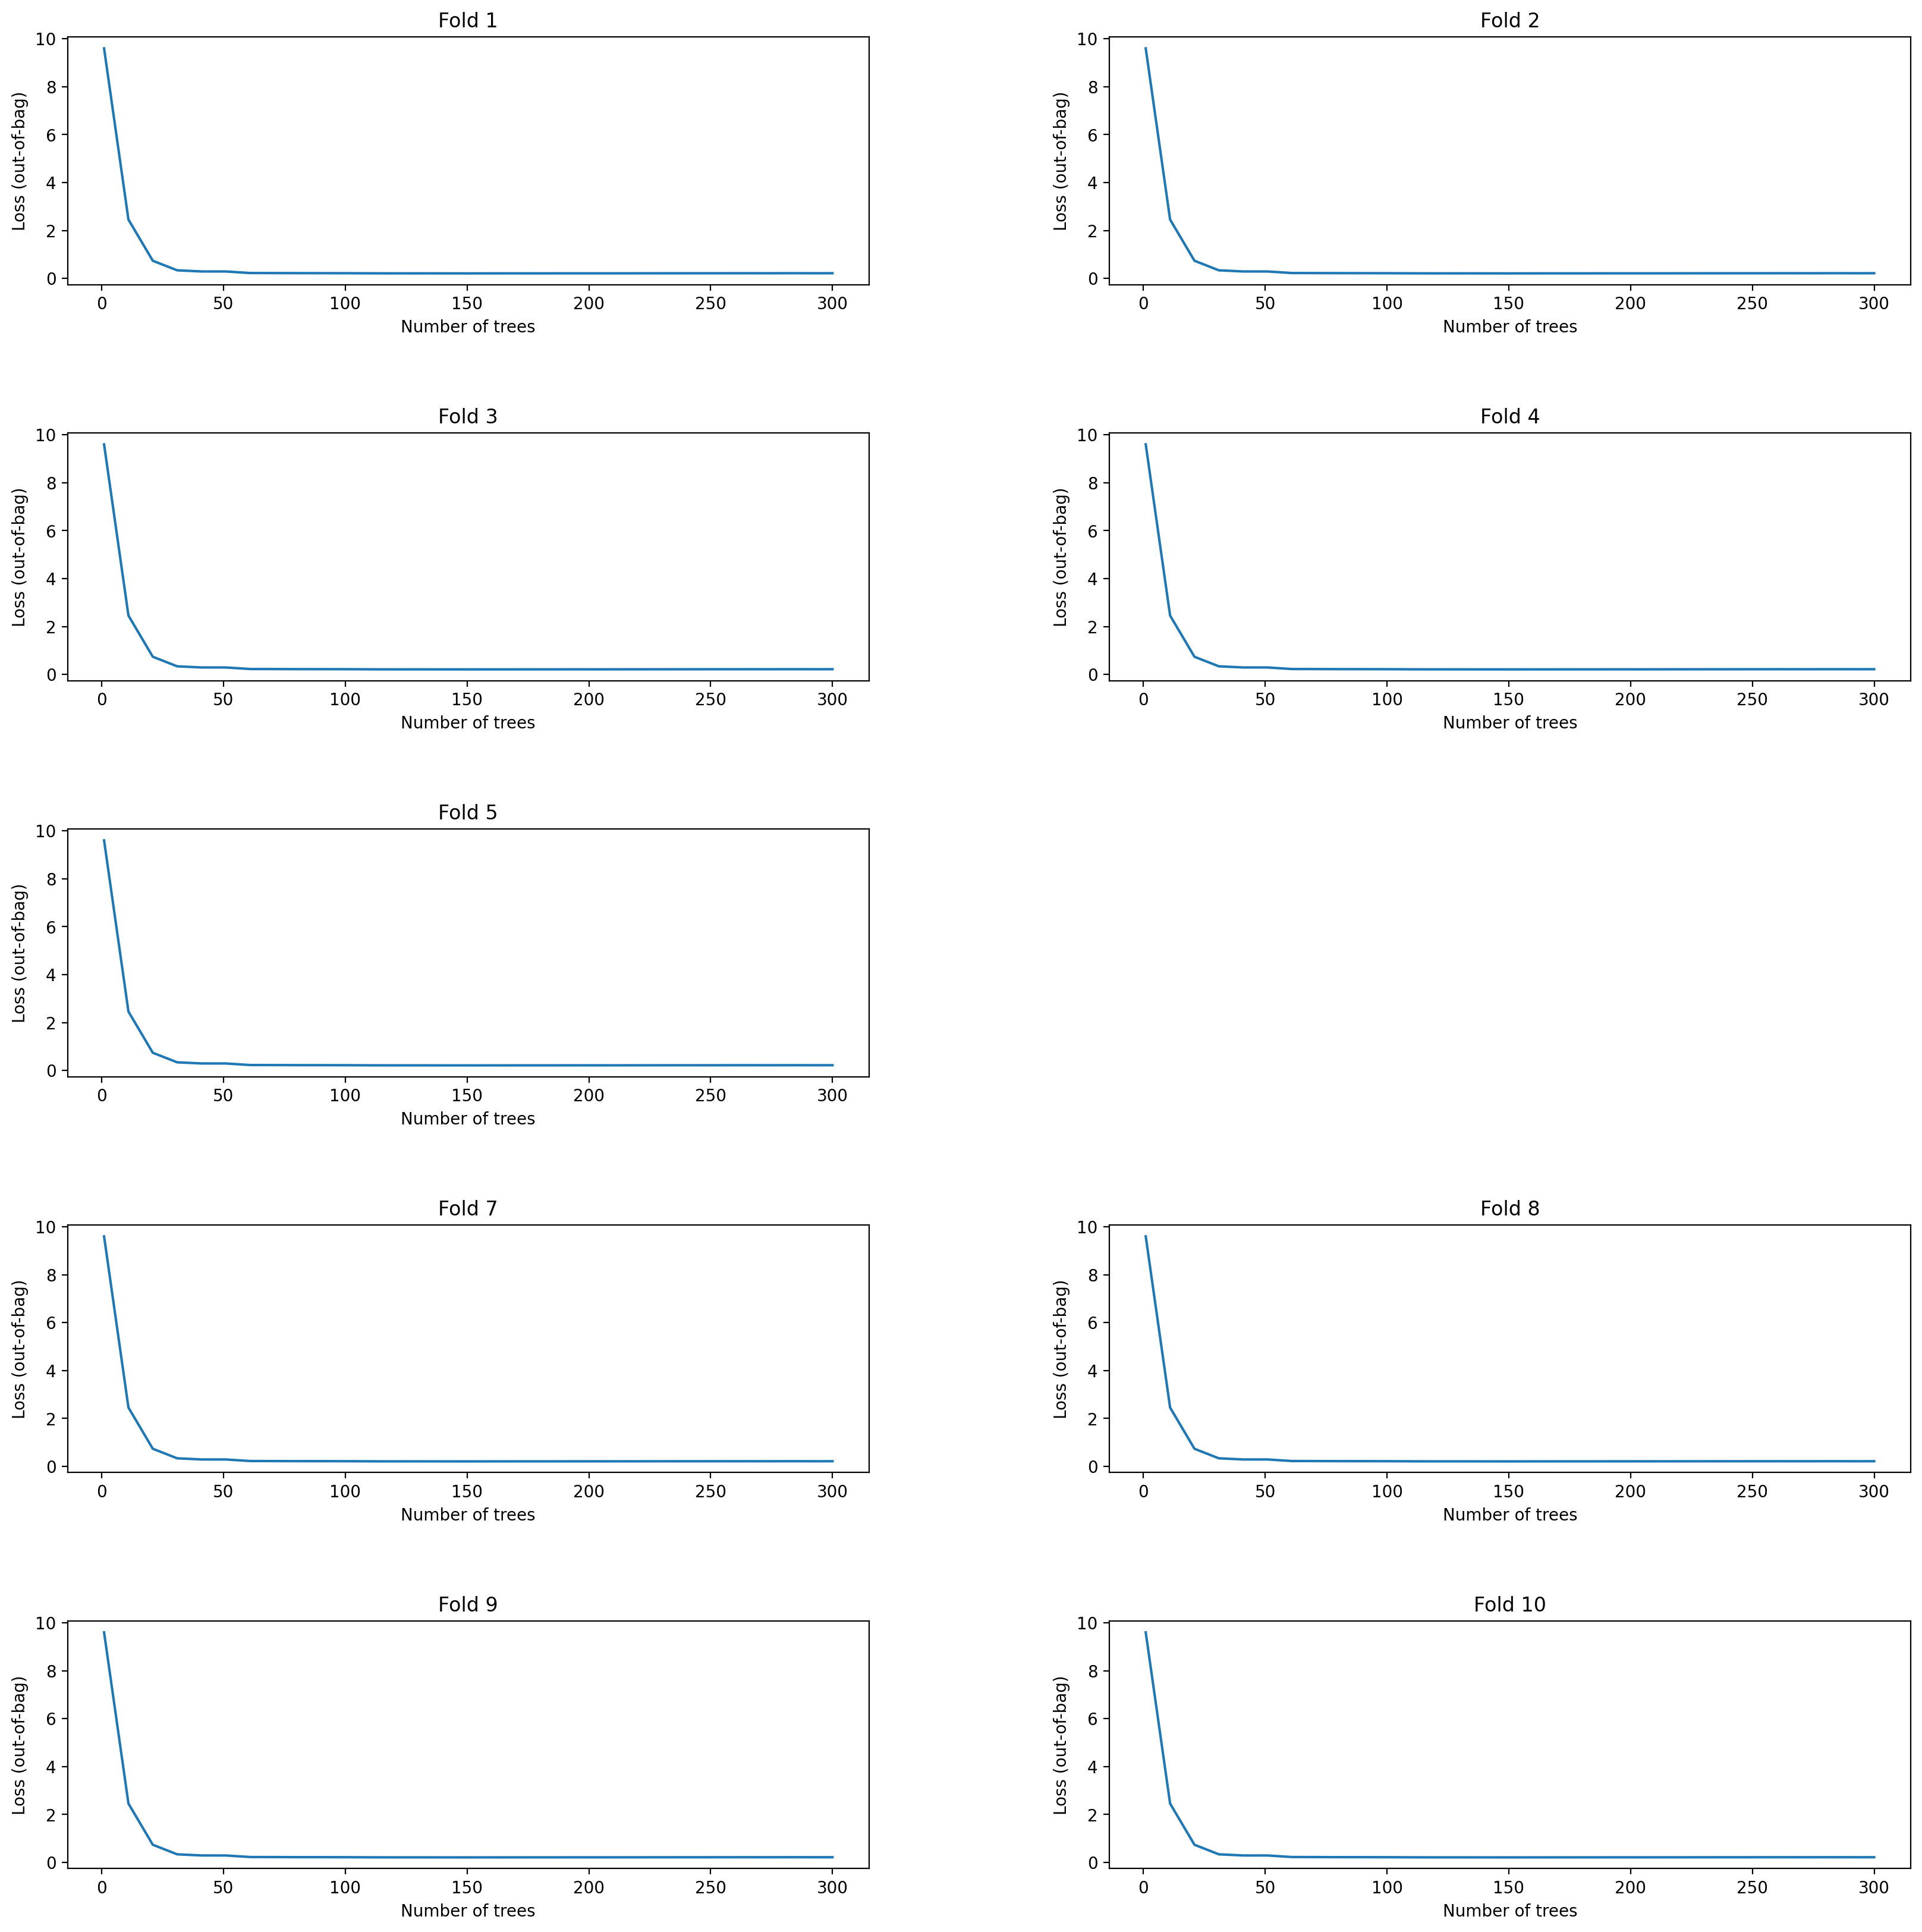

In [146]:
figure, axis = plt.subplots(5, 2, figsize=(20, 20))
plt.subplots_adjust(hspace=0.6, wspace=0.3)

for i, fold_no in enumerate(models.keys()):
    row = i//2
    col = i % 2
    logs = models[fold_no].make_inspector().training_logs()
    axis[row, col].plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    axis[row, col].set_title(f"Fold {i+1}")
    axis[row, col].set_xlabel('Number of trees')
    axis[row, col].set_ylabel('Loss (out-of-bag)')

axis[2][1].set_visible(False)
plt.show()

### Step 8: Evaluation

---

In [148]:
average_loss = 0
average_acc = 0

for _model in  models:
    average_loss += cross_entropy[_model]
    average_acc += accuracy[_model]
    print(f"{_model}: acc: {accuracy[_model]:.4f} loss: {cross_entropy[_model]:.4f}")

print(f"\nAverage accuracy: {average_acc/5:.4f}  Average loss: {average_loss/5:.4f}")

fold_1: acc: 0.9184 loss: 0.1584
fold_2: acc: 0.9184 loss: 0.1584
fold_3: acc: 0.9184 loss: 0.1584
fold_4: acc: 0.9184 loss: 0.1584
fold_5: acc: 0.9184 loss: 0.1584
fold_6: acc: 0.9184 loss: 0.1584
fold_7: acc: 0.9184 loss: 0.1584
fold_8: acc: 0.9184 loss: 0.1584
fold_9: acc: 0.9184 loss: 0.1584
fold_10: acc: 0.9184 loss: 0.1584

Average accuracy: 1.8367  Average loss: 0.3168


In [151]:
# Variable importances (NO IDEA WHAT THIS MEANS WITH PCA...)

inspector = models['fold_1'].make_inspector()

print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 NUM_AS_ROOT
	 NUM_NODES
	 SUM_SCORE
	 INV_MEAN_MIN_DEPTH


In [152]:
inspector.variable_importances()["NUM_AS_ROOT"]

[("PCA_2" (1; #2), 155.0),
 ("PCA_1" (1; #0), 84.0),
 ("PCA_6" (1; #6), 21.0),
 ("PCA_3" (1; #3), 19.0),
 ("PCA_5" (1; #5), 15.0),
 ("PCA_4" (1; #4), 3.0),
 ("PCA_9" (1; #9), 2.0),
 ("PCA_7" (1; #7), 1.0)]

`Predictions`

In [173]:
# X_test_pca as pandas df to predict

column_names = [ 'PCA_1','PCA_2','PCA_3','PCA_4','PCA_5','PCA_6','PCA_7','PCA_8','PCA_9','PCA_10']


test_pd = pd.DataFrame(X_test_pca, columns=column_names)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_pd)


predictions = models['fold_1'].predict(test_ds)

n_predictions= [[round(abs(i-1), 8), i] for i in predictions.ravel()]

print(n_predictions)

1/1 [==============================] - 0s 70ms/step
[[0.99333333, 0.006666667], [0.83333342, 0.16666658], [0.79666679, 0.20333321], [0.99666667, 0.0033333334], [0.90333336, 0.09666664], [0.99, 0.01], [0.95666666, 0.043333337], [0.91333335, 0.08666665], [0.41333377, 0.5866662], [0.98666667, 0.013333334], [0.93666666, 0.06333334], [0.94666666, 0.05333334], [0.99333333, 0.006666667], [0.82333343, 0.17666657], [0.97, 0.030000003], [0.99, 0.01], [0.13666737, 0.8633326], [1.0, 0.0], [0.83000009, 0.16999991], [0.92333334, 0.07666666], [0.15666735, 0.84333265], [0.92333334, 0.07666666], [0.77666681, 0.2233332], [0.99333333, 0.006666667], [0.64666691, 0.3533331], [0.90666669, 0.09333331], [1.0, 0.0], [0.92666667, 0.07333333], [0.91333335, 0.08666665], [0.97, 0.030000003], [0.95333333, 0.04666667], [0.90666669, 0.09333331], [0.99333333, 0.006666667], [0.95333333, 0.04666667], [1.0, 0.0], [0.13666737, 0.8633326], [0.84000008, 0.15999992], [0.99666667, 0.0033333334], [0.90666669, 0.09333331], [0.9

2023-07-16 15:03:08.239230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [124]
	 [[{{node Placeholder/_2}}]]


### Conclusions

Random Trees classifier: 
- 92% average accuracy accross 10 folds. 
- Average loss: 0.32